<a href="https://colab.research.google.com/github/AHamamd150/MLscanner/blob/main/ML_regressor_genericFunctions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model,Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
import os
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
import warnings
import tensorflow as tf
## check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found will use the CPU instead..')
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
else:
    print('Default GPU device :{}'.format(tf.test.gpu_device_name()))

Default GPU device :/device:GPU:0


In [21]:
class scan():
    '''
  This is the main class for activating all the models.
  The user has only to choose which model he/she wants with all the hyperparameters are under his/her
  control.
  '''
    
    def __init__(self,LL,function_dim,th_value,standard_deviation):
      self.th_value = th_value            #theoretical value for the function
      self.standard_deviation = standard_deviation  # Standard deviation 
      self.LL=LL                          #Accept the chi^2 larger than this value                  
      self.function_dim = function_dim    #Dimensions of the function

    'Mean absolute error'
    def mae(self,x,y):
        return (np.abs(x-y)).sum()/len(x)
    'The user has to define his function here'     
    def obs(self,x):
        F = (2+np.cos(x[:,0]/5)*np.cos(x[:,1]/7))**5
        #F = (2+np.cos(x[:,0]/7)*np.cos(x[:,1]/7)*np.cos(x[:,2]/7))**5
        return np.array(F)

    def generate_init(self,n,r1,r2):
        return np.random.uniform(r1,r2, size=(n,self.function_dim))
    'Likilihood functio.. The user can choose any other metric'
    def likelihood(self,exp_value,std,th):
        ll = np.exp(- (exp_value - th)**2/(2*std**2))
        return ll

    def run_DNN(self,runs=20,neurons = 100,activation='relu',epoch=1000,batch_size=500,batch_L=1000,batch_K=100,print_output=True):
        
        dnn = Sequential()
        dnn.add(Dense(neurons, input_shape=(self.function_dim,)))
        dnn.add(Dense(neurons, activation=activation))
        dnn.add(Dense(neurons, activation=activation))
        dnn.add(Dense(neurons, activation=activation))
        dnn.add(Dense(neurons, activation=activation))
        dnn.add(Dense(1))

        dnn.compile(optimizer='adam', loss='mse')    
        Xf=self.generate_init(batch_L,-10*np.pi,10*np.pi)
        obsf = self.obs(Xf)
        dnn.fit(Xf, obsf, epochs=epoch, verbose=0)
        X = np.empty(shape=[0,self.function_dim]) 
        obs1 = np.empty(shape=[0,1])
        for q in range(runs):
            x = self.generate_init(batch_L,-10*np.pi,10*np.pi)
            Y = self.obs(x)
            pred = dnn.predict(x).flatten()
            pred1 = self.likelihood(self.th_value,self.standard_deviation,pred)
            xsel = x[pred1>self.LL]           
            xsel1 = np.append(xsel[:round(batch_K*0.9)],x[-round(batch_K*0.1):],axis=0)
            obs2 = self.obs(xsel1)
            X = np.append(X, xsel1, axis=0)
            obs1 = np.append(obs1, obs2)
            dnn.fit(X, obs1,epochs=epoch,batch_size=batch_size, verbose=0)
            if print_output == True:
                print('DNN_model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
        dnn.save('model_dnn.h5')
        return X,obs1


    def run_GBR(self,runs=20,learning_rate=0.01,n_estimators=100,max_depth=30,batch_L=1000,batch_K=100,print_output=True):
        GBR =GradientBoostingRegressor(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)
        Xf=self.generate_init(batch_L,-10*np.pi,10*np.pi)
        obsf = self.obs(Xf)
        GBR.fit(Xf, obsf)
        X = np.empty(shape=[0,self.function_dim]) 
        obs1 = np.empty(shape=[0,1])
        for q in range(runs):
            x = self.generate_init(batch_L,-10*np.pi,10*np.pi)
            pred = GBR.predict(x).flatten()
            pred1 = self.likelihood(self.th_value,self.standard_deviation,pred)
            xsel = x[pred1>self.LL]           
            xsel1 = np.append(xsel[:round(batch_K*0.9)],x[-round(batch_K*0.1):],axis=0)
            obs2 = self.obs(xsel1)
            X = np.append(X, xsel1, axis=0)
            obs1 = np.append(obs1, obs2)
            GBR.fit(X, obs1)
            if print_output == True:
                print('GradientBoost regressor_model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
        return X,obs1
    
    def run_RFR(self,runs=20,learning_rate=0.01,n_estimators=100,max_depth=30,batch_L=1000,batch_K=100,print_output=True):
        RFR =RandomForestRegressor(n_estimators=n_estimators,max_depth=max_depth)
        Xf=self.generate_init(batch_L,-10*np.pi,10*np.pi)
        obsf = self.obs(Xf)
        RFR.fit(Xf, obsf)
        X = np.empty(shape=[0,self.function_dim]) 
        obs1 = np.empty(shape=[0,1])
        for q in range(runs):
            x = self.generate_init(batch_L,-10*np.pi,10*np.pi)
            Y = self.obs(x)
            pred = RFR.predict(x).flatten()
            pred1 = self.likelihood(self.th_value,self.standard_deviation,pred)
            xsel = x[pred1>self.LL]           
            xsel1 = np.append(xsel[:round(batch_K*0.9)],x[-round(batch_K*0.1):],axis=0)
            obs2 = self.obs(xsel1)
            X = np.append(X, xsel1, axis=0)
            obs1 = np.append(obs1, obs2)
            RFR.fit(X, obs1)
            if print_output == True:
                print('Random Forest model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
        return X,obs1


    def run_SVMRBF(self,runs=20,learning_rate=0.01,C=100, gamma=0.1, epsilon=0.1,batch_L=1000,batch_K=100,print_output=True):
        SVMRBF = SVR(kernel="rbf", C=C, gamma=gamma, epsilon=epsilon)
        Xf=self.generate_init(batch_L,-10*np.pi,10*np.pi)
        obsf = self.obs(Xf)
        SVMRBF.fit(Xf, obsf)
        X = np.empty(shape=[0,self.function_dim]) 
        obs1 = np.empty(shape=[0,1])
        for q in range(runs):
            x = self.generate_init(batch_L,-10*np.pi,10*np.pi)
            pred = SVMRBF.predict(x).flatten()
            pred1 = self.likelihood(self.th_value,self.standard_deviation,pred)
            xsel = x[pred1>self.LL]           
            xsel1 = np.append(xsel[:round(batch_K*0.9)],x[-round(batch_K*0.1):],axis=0)
            obs2 = self.obs(xsel1)
            X = np.append(X, xsel1, axis=0)
            obs1 = np.append(obs1, obs2)
            SVMRBF.fit(X, obs1)
            if print_output == True:
                print('SVR_model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
        return X,obs1


    def run_SVMPOLY(self,runs =20,degree=3, C=100, gamma=0.1, epsilon=0.1,batch_L=1000,batch_K=100,print_output=True):
        SVMPOLY = SVR(kernel="poly", degree=degree, C=C, gamma=gamma, epsilon=epsilon)
        Xf=self.generate_init(batch_L,-10*np.pi,10*np.pi)
        obsf = self.obs(Xf)
        SVMPOLY.fit(Xf, obsf)
        X = np.empty(shape=[0,self.function_dim]) 
        obs1 = np.empty(shape=[0,1])
        for q in range(runs):
            x = self.generate_init(batch_L,-10*np.pi,10*np.pi)
            pred = SVMPOLY.predict(x).flatten()
            pred1 = self.likelihood(self.th_value,self.standard_deviation,pred)
            xsel = x[pred1>self.LL]           
            xsel1 = np.append(xsel[:round(batch_K*0.9)],x[-round(batch_K*0.1):],axis=0)
            obs2 = self.obs(xsel1)
            X = np.append(X, xsel1, axis=0)
            obs1 = np.append(obs1, obs2)
            SVMPOLY.fit(X, obs1)
            if print_output == True:
                print('SVR_model- Run Number {} - Number of collected points= {}'.format(q,len(X)))
        return X,obs1    
    def plot_model(self,input,ob,title=''):
        plt.figure(figsize=(4,4))
        plt.scatter(input[:, 0],input[:, 1],c=self.likelihood(100,50,self.obs(input)),s=0.1,cmap='jet')
        plt.xlabel(r'$X_1$',fontsize=10);
        plt.ylabel(r'$X_2$',fontsize=10);
        plt.title(title,fontsize=10)
        c = plt.colorbar(orientation="horizontal");
        c.set_label('likelihood',size=10);


In [22]:
# Create an instance of the calss to access every thing 
model = scan(LL=0.9,function_dim=2,th_value=100,standard_deviation=50)

# Run the ML regression models.


In [12]:
output_dd,Y_dd =model.run_DNN(neurons = 120,activation='relu',batch_L=5000,batch_K=500,print_output=True)
output_GB,Y_GB =model.run_GBR(runs=40,n_estimators=100,batch_L=1000,batch_K=200,print_output=False)
output_RBF,Y_RBF =model.run_SVMRBF(runs=50,batch_L=1000,batch_K=200,print_output=True)
output_POLY,Y_POLY =model.run_SVMPOLY(runs =5,degree=2, C=1, gamma=0.1, epsilon=0.1,batch_K=200,print_output=True)
output_rf,Y_rf =model.run_RFR(runs=20,n_estimators=200,batch_K=200,print_output=True)

DNN_model- Run Number 0 - Number of collected points= 500
DNN_model- Run Number 1 - Number of collected points= 1000
DNN_model- Run Number 2 - Number of collected points= 1500
DNN_model- Run Number 3 - Number of collected points= 2000
DNN_model- Run Number 4 - Number of collected points= 2500
DNN_model- Run Number 5 - Number of collected points= 3000
DNN_model- Run Number 6 - Number of collected points= 3500
DNN_model- Run Number 7 - Number of collected points= 4000
DNN_model- Run Number 8 - Number of collected points= 4500
DNN_model- Run Number 9 - Number of collected points= 5000
DNN_model- Run Number 10 - Number of collected points= 5500
DNN_model- Run Number 11 - Number of collected points= 6000
DNN_model- Run Number 12 - Number of collected points= 6500
DNN_model- Run Number 13 - Number of collected points= 7000
DNN_model- Run Number 14 - Number of collected points= 7500
DNN_model- Run Number 15 - Number of collected points= 8000
DNN_model- Run Number 16 - Number of collected poin

# Optional to save the model for later use with out training


In [ ]:
model.save(dnn,dir='/home/');

# Plot the output


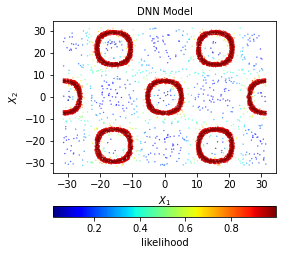

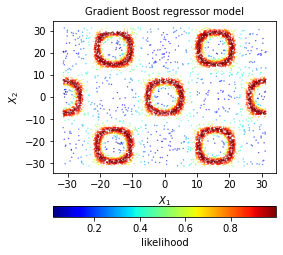

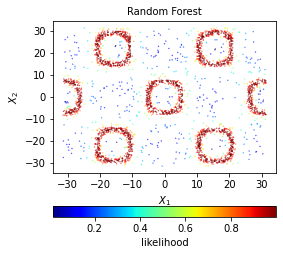

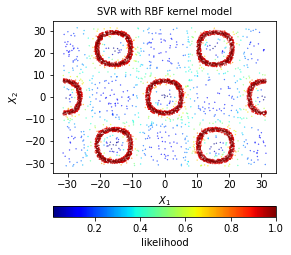

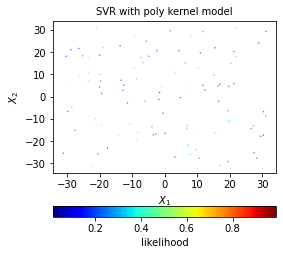

In [23]:
model.plot_model(output_dd,Y_dd,'DNN Model')
model.plot_model(output_GB,Y_GB,'Gradient Boost regressor model')
model.plot_model(output_rf,Y_rf,'Random Forest')
model.plot_model(output_RBF,Y_RBF,'SVR with RBF kernel model')
model.plot_model(output_POLY,Y_POLY,'SVR with poly kernel model')